# Unused code for composition "Anthropocène" : explorations

In [2]:
import random                  
import math
import numpy as np
from matplotlib import pyplot as plt

## 1st part : Note clouds. Movement in physical space = movement in pitch space

To describe the global movements of the species' populations, we thought it would be interesting to use sound masses (or note clouds).
We tried multiple approaches to creating these clouds, which we will describe in this section

### Various approaches

The approach here is to generate a cloud of points in a 2-dimensional regions and to associate each point to a musicale event. The x dimension should be associated to time and y dimension to pitch.

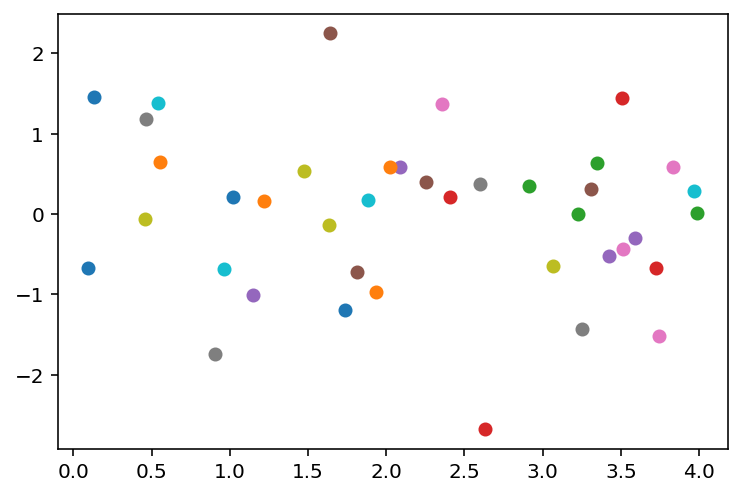

In [5]:
# Defining the number of points
n_points = 40

# We are taking here 4/4 as time signature. max_x = 4 allows to identify each integer to a beat
max_x = 4
mean = 0
dispersion = 1

def generate(n_points, max_x, dispersion, mean = 0):
    """ Generate random points [0, max_x] x R using the given parameters"""
    points = []
    for i in range(n_points):
        # the distribution of point should be uniform in time ...
        x = random.uniform(0,max_x)
        # ... but not in pitch
        y = random.gauss(mean, dispersion)
        points.append([x, y])
    for point in points:
        plt.scatter(point[0], point[1])
    
    return points

points = generate(n_points, max_x, dispersion, mean)

Then in order to associate points to musical event, one has to identify the x axes to time dimension. It has been choosen to divide the interval $[0, x_{\max}]$ into regions of a given lenght, and to gather all points of each subintervals in one event. We 'discretize' the x axis.

Concerning the y axis, the y value of the points represents a deviation to a mean value (could be either microtonale or tonale deviation : we must adapte the dispertion according to the way we will use it.

In [6]:
length = 0.25 # of a quarter

def gather(points, length = 1):
    """Collects each values of y for x in slices of length 'length'."""
    # Initializing a vector of good size
    gathered_points = []
    for i in range(int(max_x/length)):
        gathered_points.append([])
        
    # Discretizing
    for point in points:
        i = 0
        while point[0] > (i+1)*length:
            i += 1
        gathered_points[i].append(point[1])
    
    return gathered_points

gathered_points = gather(points, length)

One example of chromatic association has been shown here so that you can hear the result.

In [7]:
def get_chromatic_Notes(MAIN_NOTE, gathered_points):
    m = stream.Measure()

    for event in gathered_points:
        for i in range(len(event)):
            # Transforming number into notes with variations
            variation = event[i]
            event[i] = copy.deepcopy(MAIN_NOTE)
            event[i].pitch.midi += int(variation)
        # adding a chord made of the ste of note of each event to the measure
        m.append(chord.Chord([x for x in event]))

    return m

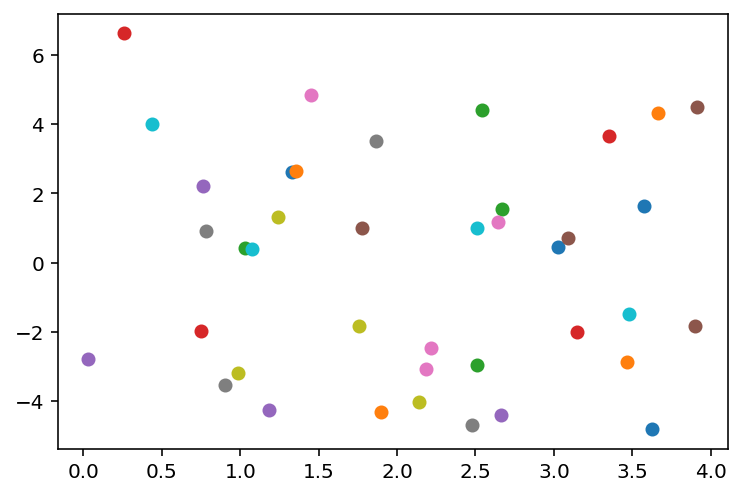

In [8]:
# All procedure is gather here so that you can rerun it easely as much as you want
n_points = 40
max_x = 4
dispersion = 3
length = 1/4 # of a quarter
MAIN_NOTE = note.Note(pitch = 'C5', quarterLength=length)
m = stream.Measure()

points = generate(n_points, max_x, dispersion, mean)
gathered_points = gather(points, length)
m = get_chromatic_Notes(MAIN_NOTE, gathered_points)

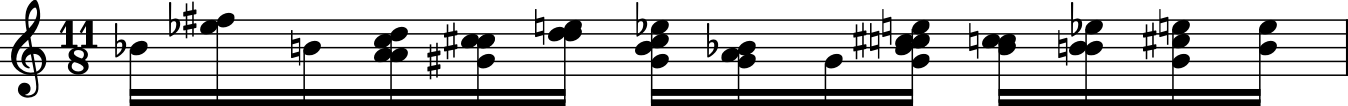

In [9]:
m.show()

In [11]:
play(m)

The finale results isn't very satisfying to hear to and do not convey the feeling of a mass of point. Therefore this procedure wasn't kept for the rest of the project.

### Moving note clouds

Here we tried extending on our previous experimentation and creating clouds which change their register and "shape" through time. Furthermore we tried to use another method for generating the points, which is simply to add notes randomly for each beat.

In [12]:
# Determines the repertoire of notes that will be used in the cloud
# In this case we used a stack of fifths C, G, D, A, E
pitches = [x for x in range(1, 128) if (x % 12) in [0, 7, 2, 9, 4]]

In [13]:
def generate_cloud(position, width, intensity, start_time, end_time, step, pitches):
    """ Generates a cloud of notes given 3 functions, which determine the position,
        width and intensity of the cloud throughout time """
    m = stream.Measure()
    t = start_time
    while t <= end_time:
        notes = [] # Determines the pitches present in the chord
        pos = position(t)
        w = width(t)
        i = intensity(t)
        # Insert each pitch candidate, which is within the range with probability i
        for p in pitches:
            if p >= pos - w and p <= pos + w:
                if random.uniform(0, 1) <= i:
                    n = note.Note(pitch=p, quarterLength = step)
                    notes.append(n)
        # If chord would be empty, insert pause instead
        if len(notes) == 0:
            m.append(note.Rest(quarterLength = step))
        else:
            c = chord.Chord(notes)
            m.append(c)
        t += step
    return m

In [14]:
m = generate_cloud(lambda t: 60 + 12*math.sin(t), 
                   lambda t: 9 + 3*math.sin(t),
                   lambda t: 0.3, 0, 16, 0.0625, pitches)

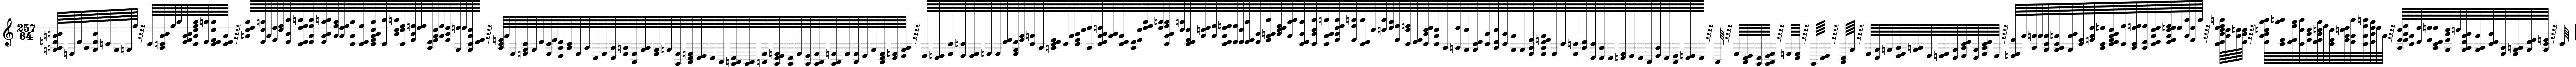

In [15]:
m.show()

In [16]:
play(m)

Through experimentation it seems a quick succession of notes works better, as with a very short interonset interval the notes seemingly blend together.

## 2nd part : Species' population simulation. Movement in physical space = movement in panning space

### First proposition

- Modelling populations as a vector and the predation rules as a matrix, thenapplying matrix multiplication would yield the population after one cycle. However this is too simplistic, as population growth does not depend only on the population of the other species, but also its own
- Next we tried generalizing the [Lotka-Volterra](https://services.math.duke.edu/education/webfeats/Word2HTML/Predator.html) model for prey-predator dynamics, however this didn't work out as I thought, since it resulted only in infrequent spikes of populations, which wouldn't be interesting for the piece
- Then we tried removing the reproduction rates (so the only cause of population growth is predation), and we started getting results which looked more interesting
- Finally we figured out keeping slight reproduction rates was useful for balancing and finding a good equilibrium
- We also tried to model how the sound masses would move - however when we tried to implement some type of accelleration towards/away from prey/predator, the positions of the individual species just diverged. Even when we tried to implement some sort of attraction to 0, to keep things in bounds, things were not very tame, so for the purpose of keeping some remotely musical structure, we had to simplify the model. So it doesn't really simulate how the species would move in space, but rather it reacts to changes in populations and tries to get closer/farther away from the initial (mean) positions of the given prey/predator. The advantage of this is that we get a periodic pattern which reflects the changes in intensity that occur.

#### Setup
Here we define the values that will govern how the system behaves. Most of the experimentation happened here, as tinkering the values to get interesting behaviour was not as easy as we thought.

In [21]:
# The populations vector represents the size of the population for each species
populations = np.array([20.0, 100.0, 300.0, 100.0])
# The positions vector attempts to model how species would try to get closer/farther to/from their prey/predator
positions = np.linspace(-1, 1, 4)

# The predation table determines which species predates on which species and with which intensity
# It is antisymmetric, since if A predates B, then B is the prey of A
predation_table = np.zeros([4, 4])
# The values are filled for predators
predation_table[0, 1] = 0.0015
predation_table[1, 2] = 0.003
predation_table[0, 2] = 0.0005
predation_table[2, 3] = 0.002
predation_table[3, 0] = 0.001
predation_table[3, 1] = 0.001
# Here the table is made antisymmetric
predation_table -= predation_table.T

print(predation_table)

# The reproduction rate represents the baseline relative change in the species population
reproduction_rates = np.array([-0.02, 0.03, 0, 0])

[[ 0.      0.0015  0.0005 -0.001 ]
 [-0.0015  0.      0.003  -0.001 ]
 [-0.0005 -0.003   0.      0.002 ]
 [ 0.001   0.001  -0.002   0.    ]]


#### Update function
Here we define the rules which the system follows and with which it evolves

In [20]:
def update(populations, positions, predation_table, reproduction_rates, dt=0.02):
    """ simulates a step of time and returns the new populations and positions """
    new_populations = populations
    new_positions = np.zeros(positions.shape)
    for i in range(0, populations.shape[0]):
        # The growth factor is basically the derivative of the population based on the Lotka-Volterra equations
        growth_factor = populations[i]*(reproduction_rates[i] + np.sum(populations*predation_table[i, :]))
        new_populations[i] += growth_factor*dt
        
        # The displacement determines essentially how species would want to move if they wanted to get closer to their prey
        # and farther from their predator
        displacement = 0
        for j in range(0, populations.shape[0]):
            if j != i:
                displacement += populations[j]*(1./(positions[i] - positions[j]))*predation_table[i, j]*0.3
        new_positions[i] = positions[i] + displacement
    return (new_populations, new_positions)

#### Simulation
Here we perform the simulation and show the results

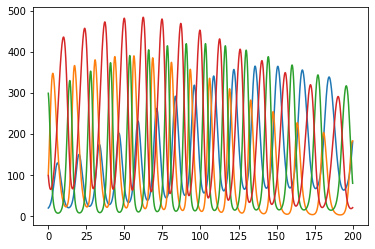

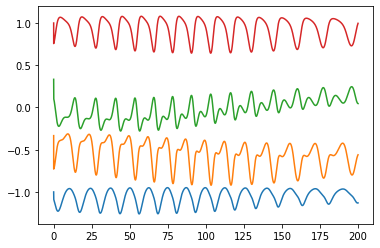

In [23]:
# Number of steps in the simulation
n_iter = 10000;
# Time step used
dt = 0.02;
# Arrays which keep track of the populations and positions over time
population_evolution = np.array([populations]);
positions_evolution = np.array([positions])
# Perform the simulation n_iter times
for i in range(1, n_iter):
    last_populations = population_evolution[-1, :]
    last_positions = positions_evolution[-1, :]
    (new_populations, new_positions) = update(last_populations, positions, predation_table, reproduction_rates, dt)
    population_evolution = np.append(population_evolution, [new_populations], axis=0)
    positions_evolution = np.append(positions_evolution, [new_positions], axis=0)

# Time intervals used for graphing
xs = [dt*x for x in range(0, n_iter)]
# Graph the populations against time
plt.plot(xs, population_evolution)
plt.show()
# Graph the positions against time
plt.plot(xs, positions_evolution)
plt.show()


We see that the behaviour this follows is periodic, which has the added perk, that if scaled properly may create a beat for the piece to follow.

### Second proposition : improvement of the first one

- Decreased species number to 3

#### Setup
Here we define the values that will govern how the system behaves

In [75]:
# The populations vector represents the size of the population for each species
populations = np.array([20.0, 100.0, 300.0])
# The positions vector attempts to model how species would try to get closer/farther to/from their prey/predator
positions = np.linspace(-1, 1, 3)

# The predation table determines which species predates on which species and with which intensity
# It is antisymmetric, since if A predates B, then B is the prey of A
predation_table = np.zeros([3, 3])
# The values are filled for predators
predation_table[0, 1] = 0.003
predation_table[1, 2] = 0.003
predation_table[0, 2] = -0.003
# Here the table is made antisymmetric
predation_table -= predation_table.T

print(predation_table)

# The reproduction rate represents the baseline relative change in the species population
reproduction_rates = np.array([-0.05, 0, +0.05])

[[ 0.     0.003 -0.003]
 [-0.003  0.     0.003]
 [ 0.003 -0.003  0.   ]]


#### Update function
Here we define the rules which the system follows and with which it evolves

In [76]:
# update simulates a step of time and returns the new populations and positions
def update(populations, positions, predation_table, reproduction_rates, dt=0.02):
    new_populations = populations
    new_positions = np.zeros(positions.shape)
    for i in range(0, populations.shape[0]):
        # The growth factor is basically the derivative of the population based on the Lotka-Volterra equations
        growth_factor = populations[i]*(reproduction_rates[i] + np.sum(populations*predation_table[i, :]))
        new_populations[i] += growth_factor*dt
        
        # The displacement determines essentially how species would want to move if they wanted to get closer to their prey
        # and farther from their predator
        accelleration = 0
        for j in range(0, populations.shape[0]):
            disp = positions[j] - positions[i];
            if j != i:
                if predation_table[i, j] > 0:
                    accelleration += populations[j]*disp/(abs(disp)**1.3)*predation_table[i, j]*0.3
                else:
                    accelleration += populations[j]*(1./disp)*predation_table[i, j]*0.3
        if accelleration > 10:
            accelleration = 10;
        if accelleration < -10:
            accelleration = -10;
        accelleration += -positions[i]
        new_positions[i] = positions[i] + accelleration*dt
    return (new_populations, new_positions)

#### Simulation
Here we perform the simulation and show the results

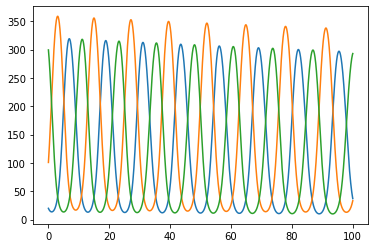

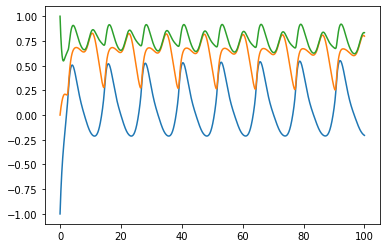

In [77]:
# Number of steps in the simulation
n_iter = 10000;
# Time step used
dt = 0.01;
# Arrays which keep track of the populations and positions over time
population_evolution = np.array([populations]);
positions_evolution = np.array([positions])
# Perform the simulation n_iter times
for i in range(1, n_iter):
    last_populations = population_evolution[-1, :]
    last_positions = positions_evolution[-1, :]
    (new_populations, new_positions) = update(last_populations, last_positions, predation_table, reproduction_rates, dt)
    population_evolution = np.append(population_evolution, [new_populations], axis=0)
    positions_evolution = np.append(positions_evolution, [new_positions], axis=0)

# Time intervals used for graphing
xs = [dt*x for x in range(0, n_iter)]
# Graph the populations against time
plt.plot(xs, population_evolution)
plt.show()
# Graph the positions against time
plt.plot(xs, positions_evolution)
plt.show()


### Third proposition : chaos

 - Describing the system with a differential system of equation, but restaining it to a finit domain $[-1,1]$ and try to have a little bit of chaos and irregularities

#### Model

Lets first define an "animal" class.

In [1]:
class Animal:
    def __init__(self, position = 0, health = 50, speed = 0, agitation = 20):
        """Position : float between -1 and 1 excluded (default : 0). Health : integer between 0 and 100 (default : 50).
           Speed : float (default : 0). Agitation : integer between 0 and 100 (default : 20)."""
        self.position_ = position
        self.health_ = health
        self.agitation_ = agitation
        self.speed_ = speed
    
    # Getters
    def getPosition(self):
        return self.position_
    
    def getHealth(self):
        return self.health_
    
    def getAgitation(self):
        return self.agitation_
    
    def getSpeed(self):
        return self.speed_
    
    # Setters
    def setPosition(self, position):
        self.position_ = position
    
    def setHealth(self, health):
        self.health_ = health
    
    def setAgitation(self, agitation):
        self.agitation_ = agitation
    
    def setSpeed(self, speed):
        self.speed_ = speed

In the following, we will consider 3 "animals" : 
 - 1 carnivor (example : Lion)
 - 1 herbivor (example : gazelle)
 - 1 plant

The lion will be denoted (1), gazelle (2) and plant (3). Their position is also associated to an $x$-coordinate.

We know that the lion want to eat the gazelle, who wants to eat the plant, who (lets suppose to) wants to eat the lion. Then lion is attracted to gazelle but fears the plant etc... One way to model it is with the following system of differential equations :
$$\ddot{x}_1 = A_1(x_2 - x_1) + B_1sgn(x_1-x_3)e^{\left( \frac{x_1-x_3}{C_1} \right)^2} - D_1sgn(x_1)\left(\frac{1}{1-|x_1|} - 1\right) - E_1\dot{x}_1^2$$
$$\ddot{x}_2 = A_2(x_3 - x_2) + B_2sgn(x_2-x_1)e^{\left( \frac{x_2-x_1}{C_2} \right)^2} - D_2sgn(x_2)\left(\frac{1}{1-|x_2|} - 1\right) - E_2\dot{x}_2^2$$
$$\ddot{x}_3 = A_3(x_1 - x_3) + B_3sgn(x_3-x_2)e^{\left( \frac{x_3-x_2}{C_3} \right)^2} - D_3sgn(x_3)\left(\frac{1}{1-|x_3|} - 1\right) - E_3\dot{x}_3^2$$
$A$ corresponds to hunger, $B$ to fear, $C$ to fear distance (from which distance do you run away from your predator), $D$ corresponds to border repulsion, and $E$ to air friction.

Lets code an engine that will do the simulation.

In [5]:
class Engine:
    def __init__(self, animals, pos_param, inter, tfin = 60, N = 1000, BC = True):
        """Animals : vector of 3 Animal. pos_param : Ex3 matrix with lign A, B, C, D, E. inter : damage/gain interaction.
        tfin : in seconds (default 60). N : number un time steps (default 1 000)."""
        # Conceptual data
        self.animals_ = animals
        self.panic() # initialize true values of aggitation
        # Position
        self.A_ = pos_param[0]
        self.B_ = pos_param[1]
        self.C_ = pos_param[2]
        self.D_ = pos_param[3]
        self.E_ = pos_param[4]
        # Health interactions
        self.interaction_ = inter
        
        # Numerical data
        self.tfin_ = tfin
        self.N_ = N
        self.dt_ = tfin/N
        self.BC_ = BC
    
    def step(self):
        """Numerical integration of differential system of equation for position (verlet algorithm).
        Changing values of agitation and health."""
        # ================== Physical movement =====================
        pos = [animal.getPosition() for animal in self.animals_]
        vel = [animal.getSpeed() for animal in self.animals_]
        acc = self.acceleration(pos, vel)
        
        next_pos = []
        for i in range(len(pos)):
            next_pos.append(pos[i] + vel[i]*self.dt_ + acc[i]*self.dt_*self.dt_/2)
        
        semi_vel = []
        for i in range(len(vel)):
            semi_vel.append(vel[i] + acc[i]*self.dt_/2)
        
        semi_acc = self.acceleration(pos, semi_vel)
        next_acc = self.acceleration(next_pos, semi_vel)
        next_vel = []
        for i in range(len(vel)):
            next_vel.append(vel[i] + (next_acc[i] + semi_acc[i])*self.dt_/2)
        
       # Imposing boundary conditions : zero speed when hit a border
        if (self.BC_):
            for i in range(len(next_pos)):
                if (next_pos[i] >= 1):
                    next_pos[i] = 1 - random.uniform(1e-5,1e-2)
                    next_vel[i] = -0
                elif (next_pos[i] <= -1):
                    next_pos[i] = -1 + random.uniform(1e-3,1e-2)
                    next_vel[i] = -0
    
        
        # ================= Agitation ==================
        self.panic()
        new_agg = []
        for animal in self.animals_:
            new_agg.append(animal.getAgitation())
        # ================== Health ====================
        self.hunt(next_pos)
        new_health = []
        for animal in self.animals_:
            new_health.append(animal.getHealth())
        
        # Position incrementation
        for i in range(len(self.animals_)):
            self.animals_[i].setPosition(next_pos[i])
            self.animals_[i].setSpeed(next_vel[i])
        
        return [next_pos, next_vel, new_agg, new_health]

    
    def acceleration(self, pos, vel):
        """Used in step. Define the velocities according to differential system of equation."""
        result = []
        a = self.A_[0]*(pos[1] - pos[0]) + self.B_[0]*np.sign(pos[0] - pos[2])*math.exp(-((pos[0] - pos[2])/self.C_[0])**2)- self.D_[0]*np.sign(pos[0])*(1/(1 - abs(pos[0]))-1) - self.E_[0]*vel[0]**2
        result.append(a)
        a = self.A_[1]*(pos[2] - pos[1]) + self.B_[1]*np.sign(pos[1] - pos[0])*math.exp(-((pos[1] - pos[0])/self.C_[1])**2) - self.D_[1]*np.sign(pos[1])*(1/(1 - abs(pos[1]))-1) - self.E_[1]*vel[1]**2
        result.append(a)
        a = self.A_[2]*(pos[0] - pos[2]) + self.B_[2]*np.sign(pos[2] - pos[1])*math.exp(-((pos[2] - pos[1])/self.C_[2])**2)- self.D_[2]*np.sign(pos[2])*(1/(1 - abs(pos[2]))-1) - self.E_[2]*vel[2]**2
        result.append(a)
        return result
    
    def hunt(self, new_pos):
        """Modify the value of health when acounter occurs. To use BEFORE incrementation of new positions."""
        # Interaction lion - gazelle
        if (np.sign(self.animals_[0].getPosition() - self.animals_[1].getPosition()) != np.sign(new_pos[0] - new_pos[1])):
            self.animals_[0].setHealth(self.animals_[0].getHealth() + self.interaction_[0])
            self.animals_[1].setHealth(self.animals_[1].getHealth() - self.interaction_[0])
        # Interaction gazelle - grass
        if (np.sign(self.animals_[1].getPosition() - self.animals_[2].getPosition()) != np.sign(new_pos[1] - new_pos[2])):
            self.animals_[1].setHealth(self.animals_[1].getHealth() + self.interaction_[1])
            self.animals_[2].setHealth(self.animals_[2].getHealth() - self.interaction_[1])
        # Interaction grass - lion
        if (np.sign(self.animals_[2].getPosition() - self.animals_[0].getPosition()) != np.sign(new_pos[2] - new_pos[0])):
            self.animals_[2].setHealth(self.animals_[2].getHealth() + self.interaction_[2])
            self.animals_[0].setHealth(self.animals_[0].getHealth() - self.interaction_[2])
    
    def panic(self):
        """Modify the value of agitation = proportionnal to the distance to the prey."""
        self.animals_[0].setAgitation(100 - round(abs(self.animals_[0].getPosition() - self.animals_[2].getPosition())*50))
        self.animals_[1].setAgitation(100 - round(abs(self.animals_[1].getPosition() - self.animals_[0].getPosition())*50))
        self.animals_[2].setAgitation(100 - round(abs(self.animals_[2].getPosition() - self.animals_[1].getPosition())*50))

    
    def run(self):
        """Run simulations. Output : t (vector of time values), carnivore, herbivore, plant.
        Animal vector are such that : lign 0 = position, lign 1 = velocity."""
        t = 0
        t_all = [0]
        carnivore = [[self.animals_[0].getPosition()], [self.animals_[0].getSpeed()], [self.animals_[0].getAgitation()], [self.animals_[0].getHealth()]]
        herbivore = [[self.animals_[1].getPosition()], [self.animals_[1].getSpeed()], [self.animals_[1].getAgitation()], [self.animals_[1].getHealth()]]
        plant = [[self.animals_[2].getPosition()], [self.animals_[2].getSpeed()], [self.animals_[2].getAgitation()], [self.animals_[2].getHealth()]]
        while (t<self.tfin_):
            [new_pos, new_vel, new_agg, new_health] = self.step()
            t += self.dt_
            t_all.append(t)
            # Add new position to vector
            carnivore[0].append(new_pos[0])
            herbivore[0].append(new_pos[1])
            plant[0].append(new_pos[2])
            # Add new velocities
            carnivore[1].append(new_vel[0])
            herbivore[1].append(new_vel[1])
            plant[1].append(new_vel[2])
            # Add new agitations
            carnivore[2].append(new_agg[0])
            herbivore[2].append(new_agg[1])
            plant[2].append(new_agg[2])
            # Add new health
            carnivore[3].append(new_health[0])
            herbivore[3].append(new_health[1])
            plant[3].append(new_health[2])
        
        return [t_all, carnivore, herbivore, plant]

Function to plot everything

In [20]:
def showall(t, carnivore, herbivore, plant):
    plt.figure(figsize=(12, 3))
    plt.plot(t, carnivore[0], label='Lion')
    plt.plot(t, herbivore[0], label='Gazelle')
    plt.plot(t, plant[0], label='Grass')
    plt.title('Position')
    plt.xlabel('t')
    plt.ylabel('x')
    plt.legend()
    plt.show()

    plt.figure(figsize=(12, 3))
    plt.plot(t, carnivore[1], label='Lion')
    plt.plot(t, herbivore[1], label='Gazelle')
    plt.plot(t, plant[1], label='Grass')
    plt.title('Velocity')
    plt.xlabel('t')
    plt.ylabel('v')
    plt.legend()
    plt.show()

    plt.figure(figsize=(12, 3))
    plt.plot(t, carnivore[2], label='Lion')
    plt.plot(t, herbivore[2], label='Gazelle')
    plt.plot(t, plant[2], label='Grass')
    plt.title('Agitation')
    plt.xlabel('t')
    plt.ylabel('a')
    plt.legend()
    plt.show()

    plt.figure(figsize=(12, 3))
    plt.plot(t, carnivore[3], label='Lion')
    plt.plot(t, herbivore[3], label='Gazelle')
    plt.plot(t, plant[3], label='Grass')
    plt.title('Health')
    plt.xlabel('t')
    plt.ylabel('H')
    plt.legend()
    plt.show()

#### Simulations : 

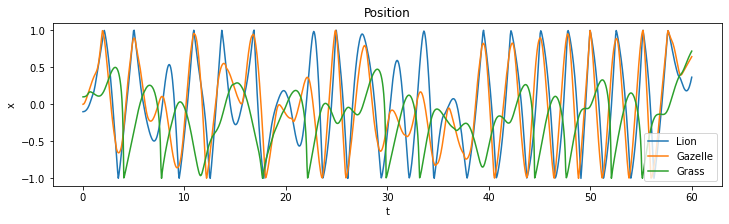

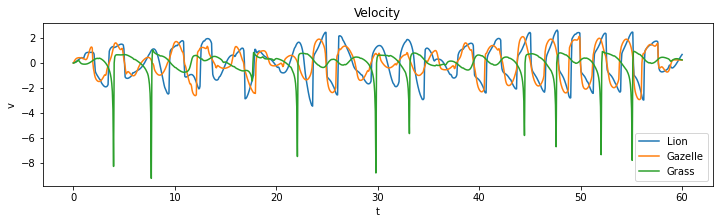

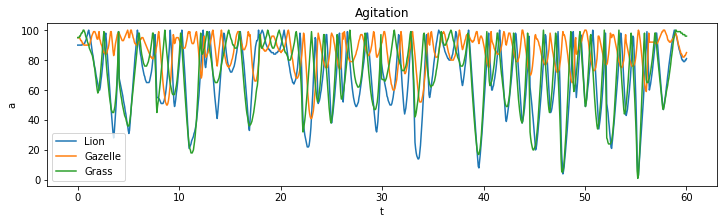

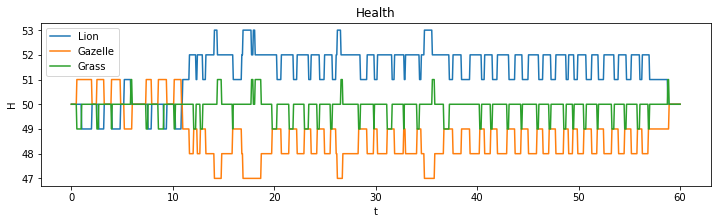

In [11]:
epsilon = 1e-3
lion    = Animal(-0.1)   # 1
gazelle = Animal()  # 2
grass   = Animal(0.1)   # 3

evolution_parametters = [[4,2,1], # faim
                        [2,4,1], # peur
                        [0.1,0.1,0.1], # distance peur
                        [1e-1,1e-1,1e-1],# repulsion bord
                        [0,0,3]] # freinage
interaction = [1,1,1]

real_engine = Engine([lion, gazelle, grass], evolution_parametters, interaction)
[t, carnivore, herbivore, plant] = real_engine.run()

showall(t, carnivore, herbivore, plant)

May be interesting :

In [12]:
evolution_parametters = [[2,1,1], # faim
                        [1,2,1], # peur
                        [0.1,0.1,0.1], # distance peur
                        [1e-1,1e-1,1e-1],# repulsion bord
                        [0,0,3]] # freinage

evolution_parametters = [[4,2,1], # faim
                        [2,4,1], # peur
                        [0.1,0.1,0.1], # distance peur
                        [1e-1,1e-1,1e-1],# repulsion bord
                        [0,0,3]] # freinage

evolution_parametters = [[4,2,1], # faim
                        [2,4,1], # peur
                        [0.1,0.1,0.1], # distance peur
                        [1e-1,1e-1,1e-1],# repulsion bord
                        [0.5,0.5,3]] # freinage

Note : there seems to be an attraction to the bottom. Indeed, in each simulation I tried they always manage to get in straight line to the lower border.